# Market Research on Restaurants in Los Angeles

Anda telah memutuskan untuk membuka sebuah kafe kecil di Los Angeles. Kafe Anda bisa dibilang cukup unik, karena Anda "memperkerjakan" robot sebagai pelayan atau pramusaji. Proyek ini memang menjanjikan, namun membutuhkan modal yang besar. Oleh karena itu, Anda dan para mitra Anda memutuskan untuk menarik minat investor. Mereka tertarik dengan kondisi pasar saat ini.

Para mitra pun meminta Anda untuk mempersiapkan sejumlah riset pasar. Anda memiliki data dari sumber terbuka (open source) terkait jenis-jenis usaha tempat makan di LA.

## Tujuan

Proyek ini berfokus pada data storytelling untuk mengikat para investor berdasarkan data Market Research. Data dilakukan pre-processing untuk membersihkan dan merapihkan data agar dapat diolah. Kemudian dilakukan analisis data untuk menentukan peluang pengembangan usaha berbasis waralaba beserta rekomendasi tentang jenis usaha dan jumlah kursinya.

### Tahapan

Data proyek analisis bisnis ini disimpan dalam file `rest_data_us.csv`

Proyek ini terdiri dari dua tahap:

1. Pra-pemrosesan Data
2. Analisis Data Exploratif (EDA)

## 1. Pra-pemrosesan Data

In [1]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from datetime import date, timedelta
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

In [2]:
# Define printmd() function to print code in blue color.
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [3]:
!pip install usaddress

In [4]:
# Import usaddress library
import usaddress

### 1.1. Memuat Data

In [5]:
# Read dataset
rest_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/rest_data_us.csv', sep=',')
rest_data.info()
display(rest_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


**Deskripsi rest_data**: 

- `id` — unik ID
- `object_name` — nama usaha
- `address` — alamat
- `chain`  — usaha berbasis waralaba (TRUE/FALSE)
- `object_type` — jenis usaha
- `number` — jumlah kursi

**Kesimpulan:**

* Tabel data `rest_data` memiliki format data yang sudah rapih.

### 1.2. Mengeksplorasi Data Awal

In [6]:
# Check total missing values descending
rest_data.isna().sum().sort_values(ascending=False)

chain          3
id             0
object_name    0
address        0
object_type    0
number         0
dtype: int64

In [7]:
# Check duplicated data
rest_data.duplicated().sum()

0

**Kesimpulan sementara:**

* Kolom `chain` terdapat nilai hilang.
* Tidak terdapat duplikat pada data.

### 1.3. Mengatasi Nilai-Nilai yang Hilang

In [8]:
rest_data[rest_data.isnull().any(axis=1)] 

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


**Kesimpulan sementara:**

* Terdapat 3 nilai yang hilang pada kolom chain.
* object_name pada id 19309 sebaiknya ditulis tanpa tada `'` untuk mempermudah analisa data.
* Ketiga data ini diketahui bukan merupakan usaha berbasis waralaba, maka dapat diisi dengan FALSE.

In [9]:
rest_data['object_name'].replace({"JAMMIN JIMMY'S PIZZA": "JAMMIN JIMMYS PIZZA"}, inplace=True)
rest_data.query('id == 19309')

,id,object_name,address,chain,object_type,number
7523,19309,JAMMIN JIMMYS PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1


In [10]:
rest_data['chain'].fillna(False, inplace = True) 
rest_data.query('id == 19194')

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,False,Restaurant,14


**Kesimpulan:**

* Data hilang telah teratasi.

### 1.4. Pre-processing - 'address' column

In [11]:
# Example street to test the library

street_example = rest_data.iloc[0]['address']
street_example

'3708 N EAGLE ROCK BLVD'

In [12]:
# Use .parse() method and pass to it any unstructed address
# The library will split it into components

usaddress.parse(street_example)

[('3708', 'AddressNumber'),
 ('N', 'StreetNamePreDirectional'),
 ('EAGLE', 'StreetName'),
 ('ROCK', 'StreetName'),
 ('BLVD', 'StreetNamePostType')]

In [13]:
# Now it's a list of tuples with the component and it's name

raw_address = usaddress.parse(street_example)

# Iterate over a list with components

dict_address = {}
for i in raw_address:
    dict_address.update({i[1]:i[0]})

dict_address

{'AddressNumber': '3708',
 'StreetNamePreDirectional': 'N',
 'StreetName': 'ROCK',
 'StreetNamePostType': 'BLVD'}

In [14]:
# Take only street name and number

dict_address['StreetNamePreDirectional'] + ',' + dict_address['StreetName'] + ',' + dict_address['AddressNumber']

'N,ROCK,3708'

In [15]:
# Apply to all our rows and include a loop that will check the addresses "without street or number"

def cleaning_check(raw):
    raw_address = usaddress.parse(raw)
    dict_address = {}
    for i in raw_address:
        dict_address.update({i[1]:i[0]})
    # Checks for normal case with street and number    
    if 'StreetName' in dict_address.keys() and 'AddressNumber' in dict_address.keys():
        clean_address = dict_address['AddressNumber'] + "," + str(dict_address['StreetName'])
        return clean_address
    else:
        return 'no street or number'

In [16]:
# Apply it to random rows

rest_data.address.sample(15).apply(cleaning_check)

3527      3929,OLYMPIC
6092        643,SPRING
5742    7000,HOLLYWOOD
4129       519,FAIRFAX
4210    6814,HOLLYWOOD
4635          3592,1ST
5219     1601,CAHUENGA
8755     3195,GLENDALE
2122        10974,PICO
1711    6706,NORMANDIE
992     1160,ROSECRANS
6649         606,OLIVE
909        4518,AVALON
6004      4442,SLAUSON
943       2000,MARENGO
Name: address, dtype: object

In [17]:
# Apply it to all data set

rest_data['clean_street_check'] = rest_data.address.apply(cleaning_check)

In [18]:
# Check what streets has no number

rest_data[rest_data['clean_street_check'] == 'no street or number']

,id,object_name,address,chain,object_type,number,clean_street_check
1888,13674,MAGDALENO DEBBIE,OLVERA ST E17,False,Restaurant,15,no street or number
3719,15505,LAS ANITAS,OLVERA ST 26,False,Restaurant,38,no street or number
7003,18789,D.K. DONUTS,1033 1/2 LOS ANGELES ST,False,Fast Food,8,no street or number
7281,19067,CIELITO LINDO,OLVERA ST 23,False,Restaurant,2,no street or number
7319,19105,JUANITA'S CAFE,OLVERA ST 20,False,Restaurant,12,no street or number
7321,19107,KITTY'S SNOW CONES,OLVERA ST 2,False,Restaurant,11,no street or number
7327,19113,LA NOCHE BUENA,OLVERA ST E8,False,Restaurant,1,no street or number
7438,19224,LA GOLONDRINA,OLVERA ST W17,False,Restaurant,204,no street or number
7741,19527,RODOLFO'S RESTAURANT,OLVERA ST 5,True,Restaurant,4,no street or number


**Kesimpulan Sementara:**

* Terdapat 2 jalan, jalan Olvera dan 1033 1/2 Los Angeles ST.

In [19]:
# Handle it with library
usaddress.parse(rest_data.iloc[1888]['address'])

[('OLVERA', 'PlaceName'), ('ST', 'StateName'), ('E17', 'ZipCode')]

**Kesimpulan Sementara:**

* Library mengatasinya dengan menyebut Olvera sebagai PlaceName dengan tanpa jalan. 

In [20]:
# Update our function

def cleaning_final(raw):
    if raw.startswith('OLVERA'):
        clean_address = 'OLVERA,Los Angeles,USA'
    elif raw.startswith('1033 1/2 LOS ANGELES'):
        clean_address = '1033 1/2 LOS ANGELES ST,Los Angeles,USA'
    else:
        raw_address = usaddress.parse(raw)
        dict_address = {}
        for i in raw_address:
            dict_address.update({i[1]:i[0]})
        clean_address = dict_address['AddressNumber'] + " " + str(dict_address['StreetName']) + str(', Los Angeles,USA')
    return clean_address

rest_data['clean_street_final'] = rest_data.address.apply(cleaning_final)
rest_data.sample(10)

,id,object_name,address,chain,object_type,number,clean_street_check,clean_street_final
2245,14031,NORTHERN CAFE,8459 BEVERLY BLVD,True,Restaurant,42,"8459,BEVERLY","8459 BEVERLY, Los Angeles,USA"
7464,19250,DEL TACO,2060 S LA CIENEGA BLVD,True,Fast Food,13,"2060,CIENEGA","2060 CIENEGA, Los Angeles,USA"
2774,14560,El HUARACHE AZTECA RESTAURANT INC.,5223 YORK BLVD,True,Restaurant,9,"5223,YORK","5223 YORK, Los Angeles,USA"
1635,13421,CROWN PLAZA EMPLOYEE CAFE,5985 W CENTURY BLVD,False,Restaurant,43,"5985,CENTURY","5985 CENTURY, Los Angeles,USA"
6398,18184,7 STAR COFFEE,421 W 7TH ST,False,Cafe,16,"421,7TH","421 7TH, Los Angeles,USA"
8318,20104,AMALIA'S RESTAURANTS,751 N VIRGIL AVE,True,Restaurant,105,"751,VIRGIL","751 VIRGIL, Los Angeles,USA"
5558,17344,ETA COCTAIL,5630 N FIGUEROA ST,False,Restaurant,36,"5630,FIGUEROA","5630 FIGUEROA, Los Angeles,USA"
7896,19682,TACOS LA PARRILLA RESTAURANT,8923 S SAN PEDRO ST,True,Fast Food,21,"8923,PEDRO","8923 PEDRO, Los Angeles,USA"
4071,15857,SUBWAY #13005,1209 S SOTO ST,True,Fast Food,1,"1209,SOTO","1209 SOTO, Los Angeles,USA"
6198,17984,PANDA GARDEN CHINESE FAST FOOD,1211 S SOTO ST,True,Restaurant,3,"1211,SOTO","1211 SOTO, Los Angeles,USA"


**Kesimpulan:**

* Data ini menyimpan data terbuka mengenai restoran di LA. Data disimpan dalam tabel `rest_data`.
* Data mengandung 9651 baris dengan mewakili satu restoran.
* Tidak terdapat data duplikat.
* Nilai hilang diatasi dengan mengisi dengan 'False' karena 3 data tersebut bukan merupakan toko waralaba.

* Kolom alamat. Untuk bekerja dengan baik dengan alamat Amerika Serikat, pustaka usaddress diimport dan kemudian membuat sebuah fungsi yang mendekonstruksi jalan hingga mendapatkan nama dan nomor jalan untuk mendapatkan alamat bersih yang disimpan di kolom yang didekonstruksi clean_street_final.

## 2. Analisis Data Exploratif (EDA)

### 2.1. Proporsi dari berbagai jenis usaha

In [21]:
rest = rest_data.groupby('object_type').agg({'id':'nunique'}).reset_index()
rest.columns = ['type','rest_count']
rest['rest_part'] = round(100 * rest['rest_count'] / rest.rest_count.sum())
rest.sort_values('rest_part', axis=0, ascending=True)

,type,rest_count,rest_part
0,Bakery,283,3.0
1,Bar,292,3.0
4,Pizza,320,3.0
2,Cafe,435,5.0
3,Fast Food,1066,11.0
5,Restaurant,7255,75.0


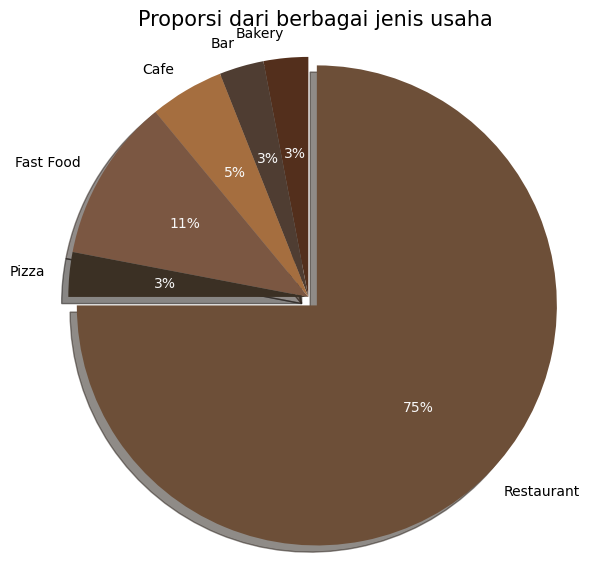

In [22]:
pie_colors = ["#532F1C", "#4F3D32", "#A56E3F", "#7B5742", "#3B3024", "#6D4F38"]

labels = rest.type
sizes = rest.rest_part
explode = (0,0,0,0,0,0.05)  

fig1, ax1 = plt.subplots(figsize=(7,7))
_, _, text = ax1.pie(sizes, explode = explode, labels = labels, autopct = '%0.0f%%',
                     shadow = True, startangle = 90, colors = pie_colors)

for t in text:
    t.set_color('#F8F8F8')

ax1.axis('equal')  

plt.title('Proporsi dari berbagai jenis usaha', fontdict={'size':15}).set_position([.5, 1.05])

plt.show()


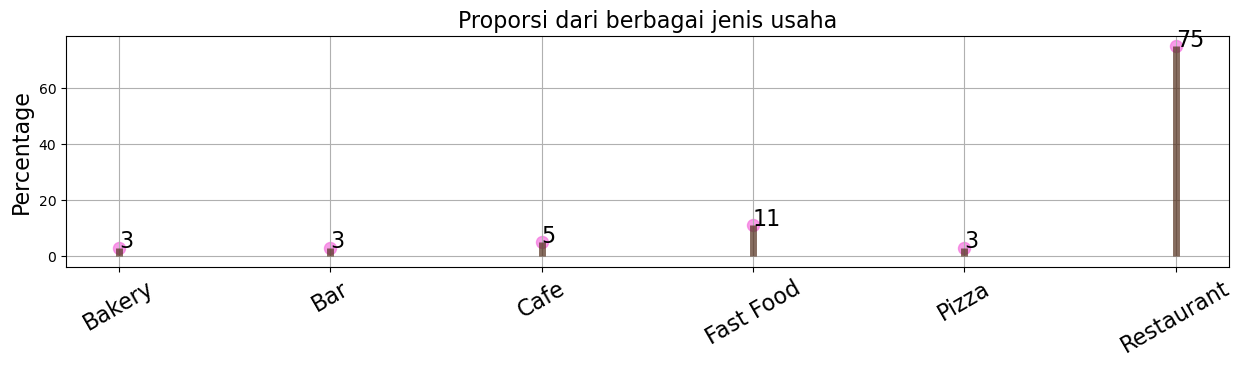

In [23]:
# Plot chart for absolute retaurant type partition

fig,ax = plt.subplots(figsize = (15,3))
plt.grid()
ax.vlines(x = rest.type, ymin = 0, ymax = rest.rest_part, color = '#532F1C', alpha = 0.7,linewidth = 5)
ax.set_title('Proporsi dari berbagai jenis usaha', fontdict = {'size':16})
ax.set_ylabel('Percentage', fontdict = {'size':16})
ax.set_xticks(rest.type)
ax.set_xticklabels(rest.type, rotation = 30, fontdict = {'size':16})

ax.scatter(x = rest.type, y = rest.rest_part, s = 75, color = '#f573df', alpha = 0.7)

for row in rest.itertuples():
    ax.text(row.type, row.rest_part, s = round(row.rest_part), fontdict = {'size':16})

**Kesimpulan sementara:**

* Data terlihat bahwa 75% adalah restoran, 3% adalah Toko roti, bar, dan toko pizza, 5% adalah kafe dan 11% adalah makanan cepat saji.

### 2.2.  Proporsi dari usaha berbasis waralaba dan nonwaralaba

In [24]:
rest_type = rest_data.groupby(['object_type','chain']).agg({'id':'nunique'}).reset_index()
rest_type.columns = ['type','chain','rest_count']
rest_type['rest_part'] = round(
    100 * rest_type['rest_count'] / rest_type.rest_count.sum())

# Change chain column from True False to Chain Not-chain values

rest_type['chain'] = rest_type['chain'].astype(str).replace({'True':'Chain', 'False':'Not-chain'})

In [25]:
rest_type["type_chain"] = rest_type['type'] + " " + rest_type['chain'].astype(str)

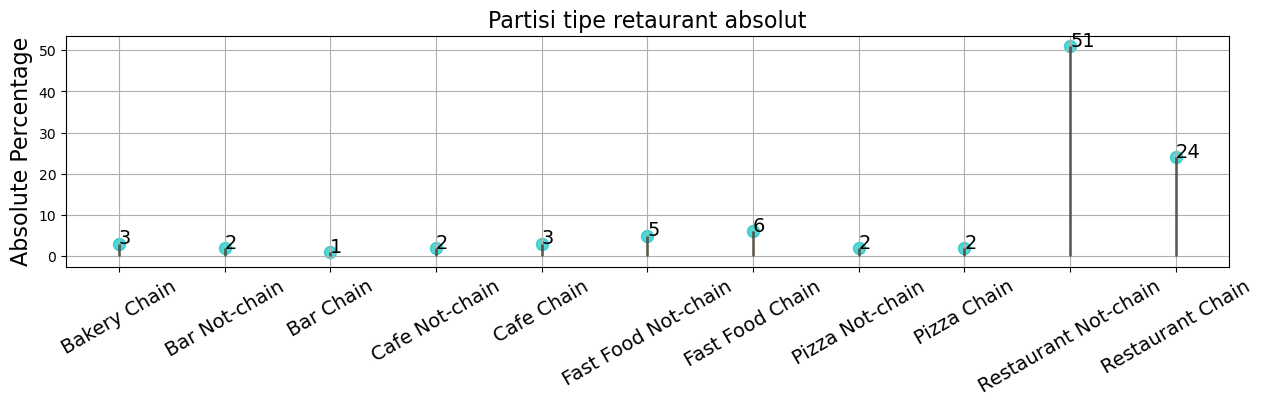

In [26]:
# Plot chart for absolute retaurant type partition 
fig,ax = plt.subplots(figsize = (15,3))
plt.grid()
ax.vlines(x = rest_type.type_chain, ymin = 0,
          ymax = rest_type.rest_part, color = '#3B3024', alpha = 0.7,linewidth = 2)
ax.set_title('Partisi tipe retaurant absolut', fontdict = {'size':16})
ax.set_ylabel('Absolute Percentage', fontdict = {'size':16})
ax.set_xticks(rest_type.type_chain)
ax.set_xticklabels(rest_type.type_chain, rotation = 30, fontdict = {'size':14})

ax.scatter(x=rest_type.type_chain, y=rest_type.rest_part, s = 75, color = '#10c4c0', alpha = 0.7)

for row in rest_type.itertuples():
    ax.text(row.type_chain, row.rest_part, s = round(row.rest_part), fontdict = {'size':14})

In [27]:
# Pivot table for graph inside each category
pv_rest_type = rest_data.pivot_table(index = 'object_type', columns = 'chain', values = 'id', aggfunc = 'count')
rest_type_t = pv_rest_type.T
rest_type_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, False to True
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bakery      1 non-null      float64
 1   Bar         2 non-null      float64
 2   Cafe        2 non-null      float64
 3   Fast Food   2 non-null      float64
 4   Pizza       2 non-null      float64
 5   Restaurant  2 non-null      float64
dtypes: float64(6)
memory usage: 112.0+ bytes


object_type,Bakery,Bar,Cafe,Fast Food,Pizza,Restaurant
chain,,,,,,
False,NaN,3.598326,2.828452,7.715481,2.794979,83.062762
True,7.698585,2.094668,7.236126,16.458107,4.162133,62.350381


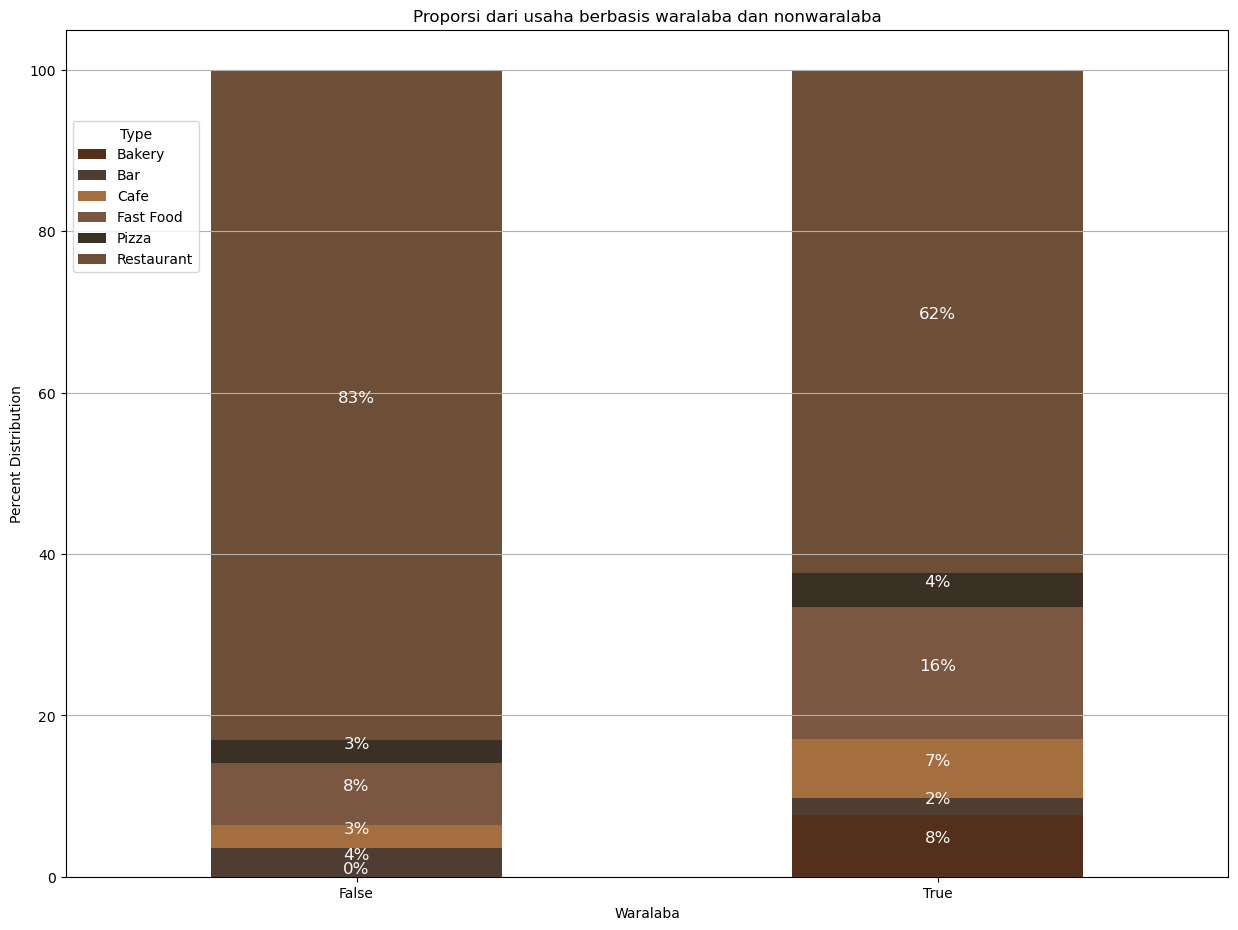

In [28]:
bar_colors = ["#532F1C", "#4F3D32", "#A56E3F", "#7B5742", "#3B3024", "#6D4F38"]

ax = rest_type_t.apply(lambda r: r/r.sum()*100, axis = 1)
ax_1 = ax.plot.bar(figsize = (15,11),stacked = True, rot = 0, color = bar_colors)
display(ax)

plt.legend(loc = 'upper center', bbox_to_anchor = (0.06, 0.9), title = "Type")

plt.xlabel('Waralaba')
plt.ylabel('Percent Distribution')

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              color = '#F8F8F8',
              fontsize=12,
              ha = 'center', 
              va = 'bottom')
plt.title('Proporsi dari usaha berbasis waralaba dan nonwaralaba')
plt.grid(axis = 'y')
plt.show()

**Kesimpulan sementara:**

* Restoran nonwaralaba lebih banyak dibandingkan restoran waralaba.
* Toko roti waralaba di LA mewakili 8% toko-toko waralaba. Sedangkan nonwaralaba hanya 0%.

### 2.3.  Jenis usaha yang berbasis waralaba

In [29]:
chain = rest_type.query('chain == "Chain"')

In [30]:
rest_type

,type,chain,rest_count,rest_part,type_chain
0,Bakery,Chain,283,3.0,Bakery Chain
1,Bar,Not-chain,215,2.0,Bar Not-chain
2,Bar,Chain,77,1.0,Bar Chain
3,Cafe,Not-chain,169,2.0,Cafe Not-chain
4,Cafe,Chain,266,3.0,Cafe Chain
5,Fast Food,Not-chain,461,5.0,Fast Food Not-chain
6,Fast Food,Chain,605,6.0,Fast Food Chain
7,Pizza,Not-chain,167,2.0,Pizza Not-chain
8,Pizza,Chain,153,2.0,Pizza Chain
9,Restaurant,Not-chain,4963,51.0,Restaurant Not-chain


In [31]:
pv_rest_type

chain,False,True
object_type,,
Bakery,NaN,283.0
Bar,215.0,77.0
Cafe,169.0,266.0
Fast Food,461.0,605.0
Pizza,167.0,153.0
Restaurant,4963.0,2292.0


In [32]:
chain['chain_part']=round(100 * chain['rest_count'] / chain.rest_count.sum())
chain

,type,chain,rest_count,rest_part,type_chain,chain_part
0,Bakery,Chain,283,3.0,Bakery Chain,8.0
2,Bar,Chain,77,1.0,Bar Chain,2.0
4,Cafe,Chain,266,3.0,Cafe Chain,7.0
6,Fast Food,Chain,605,6.0,Fast Food Chain,16.0
8,Pizza,Chain,153,2.0,Pizza Chain,4.0
10,Restaurant,Chain,2292,24.0,Restaurant Chain,62.0


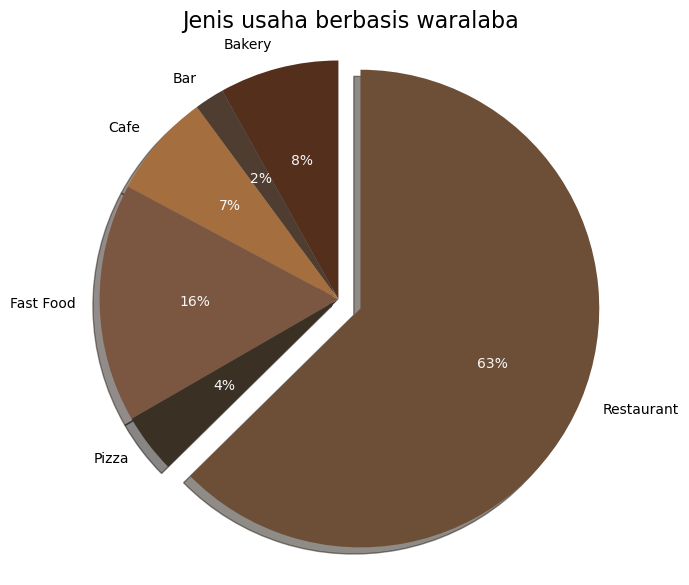

In [33]:
pie_colors = ["#532F1C", "#4F3D32", "#A56E3F", "#7B5742", "#3B3024", "#6D4F38"]

labels = chain.type
sizes = chain.chain_part
explode = (0,0,0,0,0,0.1)  

fig1, ax1 = plt.subplots(figsize = (7,7))
_, _, text = ax1.pie(sizes, explode = explode, labels = labels, autopct = '%1.0f%%',
        shadow = True, startangle = 90, colors = pie_colors)

for t in text:
    t.set_color('#F8F8F8')

ax1.axis('equal')  
plt.title('Jenis usaha berbasis waralaba', fontdict = {'size':16})

plt.show()

**Kesimpulan sementara:**

* Data waralaba terlihat Restoran sebanyak (63%), fast-food (16%), toko roti (8%) dan kafe (7%).

### 2.4.  Karakteristik jenis usaha berbasis waralaba

Memiliki banyak tempat dengan jumlah kursi yang sedikit atau memiliki beberapa tempat dengan jumlah kursi yang banyak?

In [34]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [35]:
rest_data.query('chain == True')['number'].max()

229

In [36]:
rest_data.query('chain == True')['number'].describe()

count    3676.000000
mean       39.694233
std        43.437212
min         1.000000
25%        13.000000
50%        25.000000
75%        44.000000
max       229.000000
Name: number, dtype: float64

In [37]:
rest_data.query('chain == True')['number'].value_counts().sort_values(ascending=False).describe()

count    203.000000
mean      18.108374
std       26.401097
min        1.000000
25%        2.000000
50%        5.000000
75%       10.000000
max       99.000000
Name: number, dtype: float64

**Kesimpulan sementara:**

* Terdapat 203 jenis jumlah kursi yang berbeda di restoran waralaba
* Mulai dari 1 sebagai jumlah minimum hingga 229 sebagai jumlah maksimum. Rata-rata, ada 39 kursi. 
* 25% dari restoran waralaba memiliki 13 kursi, 50% memiliki 25 kursi, dan 75% memiliki 44 kursi.

In [38]:
seats_chain=rest_data.query('chain == True')['number']

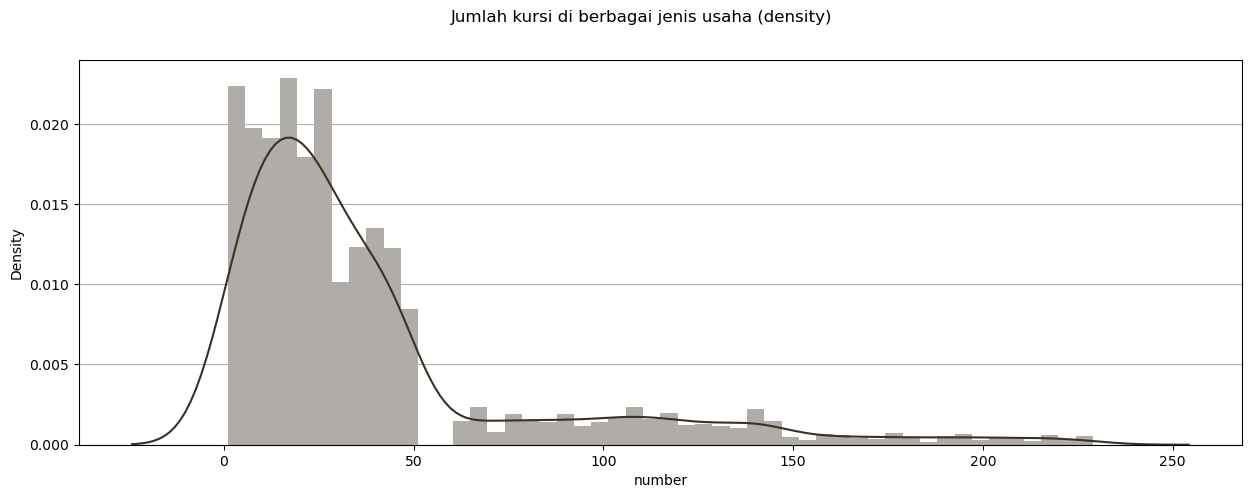

In [39]:
plt.figure(figsize = (15,5))
lst1 = seats_chain
plt.grid(axis = 'y')
sns.distplot(lst1,label = 'number of seats', color = "#3B3024")
#plt.subplots_adjust(top=0.9)
plt.suptitle('Jumlah kursi di berbagai jenis usaha (density)')
plt.show()

**Kesimpulan:**

* Berdasarkan grafik, bahwa ada banyak perusahaan dengan jumlah kursi yang sedikit (di bawah 50 kursi) dan lebih sedikit perusahaan dengan banyak kursi.

### 2.5.  Jumlah rata-rata kursi untuk setiap jenis usaha

Jenis usaha manakah yang memiliki jumlah kursi terbanyak?

In [40]:
rest_seat = rest_data.groupby('object_type').agg(
    {'id':'nunique','number':'mean'}).reset_index()
rest_seat.columns = ['type','rest_count','avg_seat']
rest_seat=rest_seat.sort_values('avg_seat', axis = 0, ascending = False)

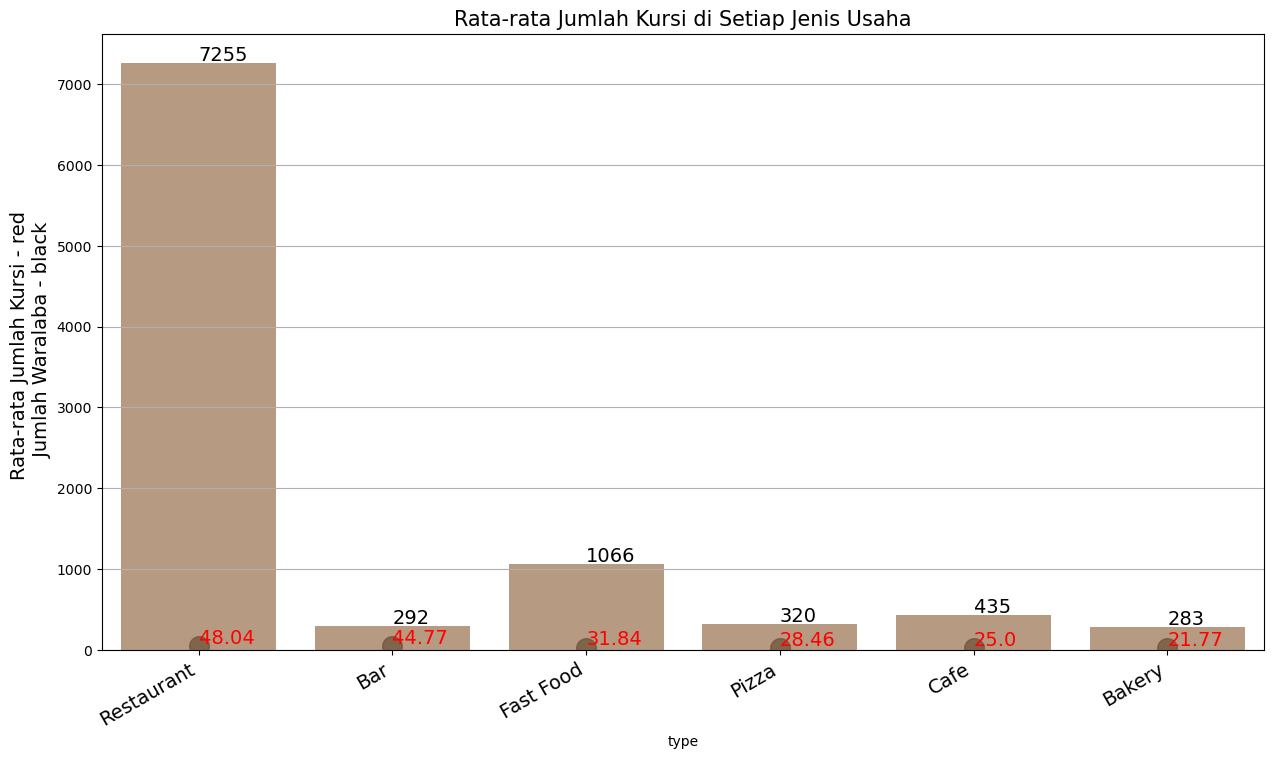

In [41]:
fig,ax = plt.subplots(figsize = (15,8))

ax.scatter(x = rest_seat.type,
           y = rest_seat.avg_seat, 
           s = 200, color = 'black', 
           alpha = 0.7)
sns.barplot(x = rest_seat.type, 
            y = rest_seat.rest_count, 
            color = '#A56E3F', 
            alpha = 0.7)
plt.grid(axis = 'y')
ax.set_title(
    'Rata-rata Jumlah Kursi di Setiap Jenis Usaha', fontdict = {'size':15})
ax.set_ylabel(
    'Rata-rata Jumlah Kursi - red \n Jumlah Waralaba - black', fontdict = {'size':14})
ax.set_xticks(rest_seat.type)
ax.set_xticklabels(
    rest_seat.type,
    rotation = 30,
    fontdict = {'horizontalalignment':'right','size':14}
)
for row in rest_seat.itertuples():
    ax.text(
        row.type, row.avg_seat+30, 
        s = round(row.avg_seat, 2), 
        color = 'red',
        fontdict = {'size':14}
    ),
    ax.text(
        row.type, 
        row.rest_count+30, 
        s = round(row.rest_count, 0),
        fontdict = {'size':14}
    ) 

**Kesimpulan:**

* Menurut data, rata-rata jumlah kursi di berbagai jenis usaha di rumah makan (48), bar (44), fast-food (32), tempat pizza (28), kafe (25), dan toko roti (22).

### 2.6.  Data nama jalan dari kolom address ke kolom terpisah.

In [42]:
# Add column "street_raw" 
rest_data['street_number_raw'] = rest_data['address']
rest_data[['street_number_raw','street_raw']] = rest_data['street_number_raw'].str.split(n = 1,expand = True)
rest_data= rest_data[['id','object_name','chain','object_type','number','clean_street_final','address','street_raw']]
rest_data.head()

,id,object_name,chain,object_type,number,clean_street_final,address,street_raw
0,11786,HABITAT COFFEE SHOP,False,Cafe,26,"3708 ROCK, Los Angeles,USA",3708 N EAGLE ROCK BLVD,N EAGLE ROCK BLVD
1,11787,REILLY'S,False,Restaurant,9,"100 WORLD, Los Angeles,USA",100 WORLD WAY # 120,WORLD WAY # 120
2,11788,STREET CHURROS,False,Fast Food,20,"6801 HOLLYWOOD, Los Angeles,USA",6801 HOLLYWOOD BLVD # 253,HOLLYWOOD BLVD # 253
3,11789,TRINITI ECHO PARK,False,Restaurant,22,"1814 SUNSET, Los Angeles,USA",1814 W SUNSET BLVD,W SUNSET BLVD
4,11790,POLLEN,False,Restaurant,20,"2100 PARK, Los Angeles,USA",2100 ECHO PARK AVE,ECHO PARK AVE


In [43]:
rest_data.street_raw.value_counts().nunique()

74

**Kesimpulan Sementara:**

* Terdapat 74 nama jalan.

In [44]:
# Add column "street" based on the US address analysis
rest_data['street_number'] = rest_data['clean_street_final']
rest_data[['street_number','street']] = rest_data['street_number'].str.split(n = 1,expand = True)
rest_data[['street','city']] = rest_data['street'].str.split(n = 1,expand = True)
rest_data = rest_data[['id','object_name','chain','object_type','number','clean_street_final','address','street','street_raw']]
rest_data.head()

,id,object_name,chain,object_type,number,clean_street_final,address,street,street_raw
0,11786,HABITAT COFFEE SHOP,False,Cafe,26,"3708 ROCK, Los Angeles,USA",3708 N EAGLE ROCK BLVD,"ROCK,",N EAGLE ROCK BLVD
1,11787,REILLY'S,False,Restaurant,9,"100 WORLD, Los Angeles,USA",100 WORLD WAY # 120,"WORLD,",WORLD WAY # 120
2,11788,STREET CHURROS,False,Fast Food,20,"6801 HOLLYWOOD, Los Angeles,USA",6801 HOLLYWOOD BLVD # 253,"HOLLYWOOD,",HOLLYWOOD BLVD # 253
3,11789,TRINITI ECHO PARK,False,Restaurant,22,"1814 SUNSET, Los Angeles,USA",1814 W SUNSET BLVD,"SUNSET,",W SUNSET BLVD
4,11790,POLLEN,False,Restaurant,20,"2100 PARK, Los Angeles,USA",2100 ECHO PARK AVE,"PARK,",ECHO PARK AVE


In [45]:
rest_data.street.value_counts().nunique()

85

**Kesimpulan Sementara:**

* Terdapat 85 nama jalan berdasarkan analisis alamat US.

### 2.7.  Sepuluh nama jalan teratas berdasarkan jumlah usaha (tempat makan).

In [46]:
rest_street = rest_data.query('object_type == "Restaurant"').groupby(['street']
                               ).agg({'id':'nunique'}).reset_index().sort_values(by = 'id', ascending = False)
rest_street.head(10)

,street,id
415,"WILSHIRE,",319
370,"SUNSET,",297
408,"WESTERN,",292
320,"PICO,",283
304,"OLYMPIC,",257
168,"FIGUEROA,",234
387,"VERMONT,",218
20,"3RD,",208
283,"MONICA,",204
214,"HOLLYWOOD,",197


In [47]:
rest_street_raw = rest_data.query('object_type == "Restaurant"').groupby(['street_raw']
                               ).agg({'id':'nunique'}).reset_index().sort_values(by = 'id', ascending = False)

In [48]:
rest_street_raw.columns = ['street','n_rest']
raw_top10 = rest_street_raw.head(10)
raw_top10

,street,n_rest
2133,W PICO BLVD,218
2184,W SUNSET BLVD,217
471,HOLLYWOOD BLVD,136
2302,WILSHIRE BLVD,131
1757,W 3RD ST,119
1550,SANTA MONICA BLVD,107
2058,W OLYMPIC BLVD,107
1379,S VERMONT AVE,107
613,MELROSE AVE,106
125,BEVERLY BLVD,103


In [49]:
rest_street.columns = ['street','n_rest']
top10 = rest_street.head(10)

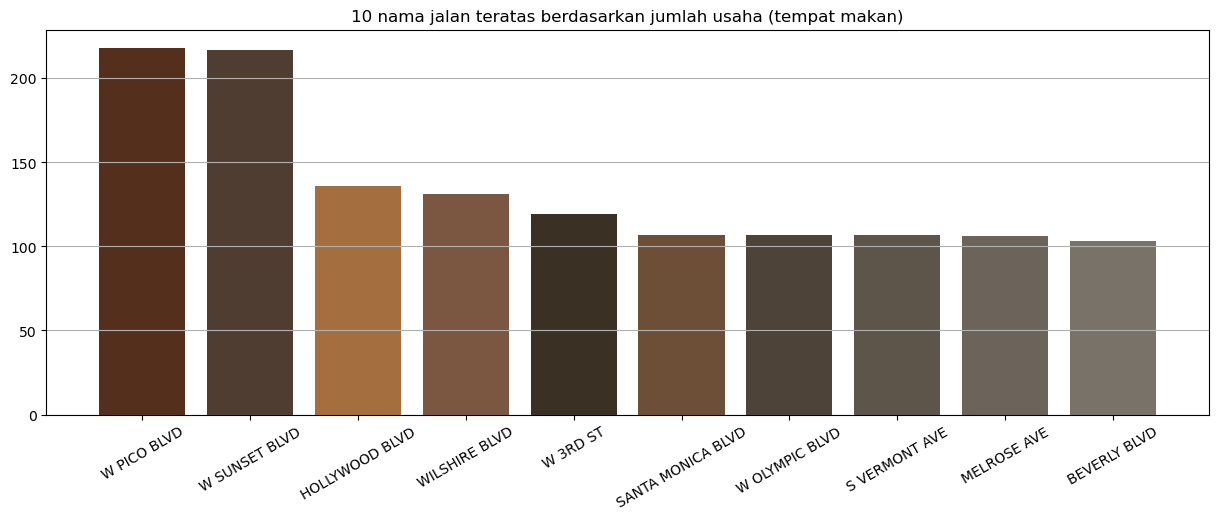

In [50]:
plt.figure(figsize = (15,5))
plt.title('10 nama jalan teratas berdasarkan jumlah usaha (tempat makan)')
y_pos = np.arange(len(top10.n_rest))
plt.bar(y_pos, raw_top10.n_rest,
        color = ["#532F1C", "#4F3D32", "#A56E3F", "#7B5742", "#3B3024", "#6D4F38", "#4D4338", "#5D544A", "#6C645A", "#797269"])
plt.xticks(y_pos, raw_top10.street)
plt.xticks(rotation = 30)
plt.grid(axis = 'y')
plt.show()

**Kesimpulan:**

* Berdasarkan data jalan teratas yaitu 3 boulevard yaitu West Pico, West Sunset, dan Hollywood dengan 218, 217 dan 136 restaurants secara berurutan.

### 2.8.  Jumlah jalan yang hanya memiliki satu usaha (tempat makan)

In [51]:
rest_street.query('n_rest == 1')['street'].nunique()

179

**Kesimpulan:**

* Berdasarkan data, terdapat 179 restoran (tempat makan) yang hanya memiliki 1 usaha disetiap jalan.

### 2.9.  Jalan yang dihuni oleh banyak usaha (tempat makan)

In [52]:
rest_street_raw_seats = rest_data.query('object_type=="Restaurant"').groupby(['street_raw']
                               ).agg({'id':'nunique', 'number':'mean'}).reset_index().sort_values(by ='id', ascending=False)
rest_street_raw_seats.head(10)

,street_raw,id,number
2133,W PICO BLVD,218,45.215596
2184,W SUNSET BLVD,217,55.705069
471,HOLLYWOOD BLVD,136,58.441176
2302,WILSHIRE BLVD,131,67.068702
1757,W 3RD ST,119,47.655462
1550,SANTA MONICA BLVD,107,35.158879
2058,W OLYMPIC BLVD,107,59.644860
1379,S VERMONT AVE,107,47.841121
613,MELROSE AVE,106,55.216981
125,BEVERLY BLVD,103,51.873786


In [53]:
rest_street_raw_seats.columns = ['street','n_rest','avg_seats']
top15 = rest_street_raw_seats.head(15)
top15 = top15.sort_values(by = 'avg_seats', ascending = False)

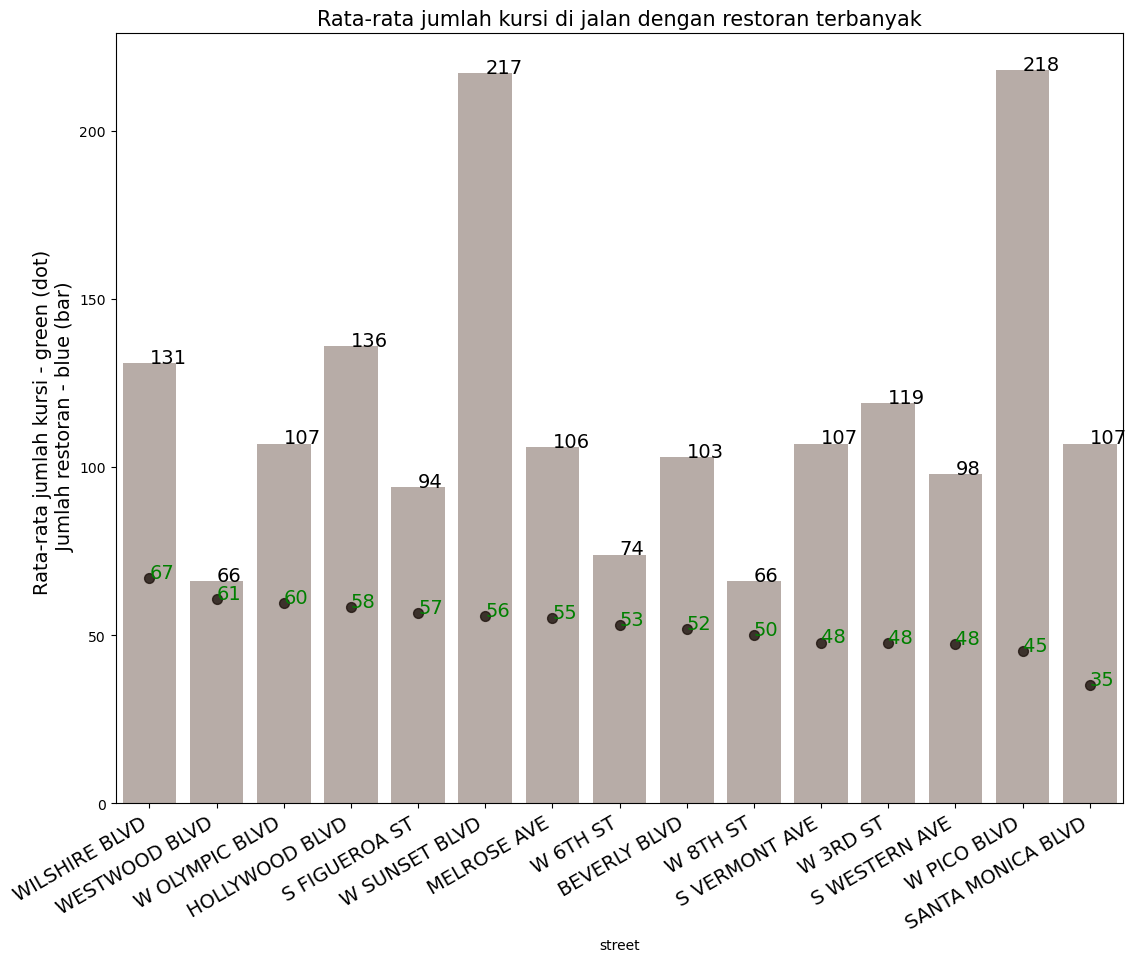

In [54]:
fig,ax = plt.subplots(figsize = (13,10))

ax.scatter(x = top15.street,
           y = top15.avg_seats, 
           s = 50, color = 'black', 
           alpha = 0.8)

sns.barplot(x = top15.street, 
            y = top15.n_rest, 
            color = '#532F1C', 
            alpha = 0.4)

ax.set_title(
    'Rata-rata jumlah kursi di jalan dengan restoran terbanyak', fontdict = {'size':15})
ax.set_ylabel(
    'Rata-rata jumlah kursi - green (dot) \n Jumlah restoran - blue (bar)', fontdict = {'size':14})
ax.set_xticks(top15.street)
ax.set_xticklabels(
    top15.street,
    rotation = 30,
    fontdict = {'horizontalalignment':'right','size':14}
)
for row in top15.itertuples():
    ax.text(
        row.street, row.avg_seats, 
        s = round(row.avg_seats), 
        color = 'green',
        fontdict = {'size':14}
    ),
    ax.text(
        row.street, 
        row.n_rest, 
        s = round(row.n_rest),
        fontdict = {'size':14}
    ) 

**Kesimpulan:**

* Berdasarkan data dari 15 jalan dengan restoran terbanyak, rata-rata tertinggi jumlah kursi yaitu di jalan Wilshire boulevards (67), Westwood boulevard (61), dan W Olympic boulevard (60).

## Kesimpulan Umum

#### A. Pra-pemrosesan

Dari eksplorasi pra-pemrosesan data, dapat disimpulkan bahwa:
1. Data menyangkut data terkait jenis usaha tempat makan di LA. Missing value hanya terdapat 3 data dan dapat diisi dengan nilai False karena setelah diteliti bukan merupakan toko waralaba. Apabila ada kesalahanpun tidak akan mempengaruhi keseluruhan data secara impact.
2. Duplikat data tidak ditemukan.
3. Untuk mempermudah analisis data, dilakukan import alamat US. Kemudian dibuat fungsi untuk mendekonstruksi jalan sehingga didapatkan nama dan nomor jalan untuk mendapatkan alamat yang bersih.


#### B. Analisis Data Esksploratif (EDA)

Dari hasil analisis data esksploratif, dapat disimpulkan bahwa:
1. Secara proporsi dari berbagai jenis usaha, 75% adalah restoran, 11% adalah makanan cepat saji, 5% adalah kafe, dan 3% adalah toko roti, bar, dan tempat pizza.
2. Proporsi dari berbagai jenis usaha, usaha tempat makan nonwaralaba memiliki tingkat tertinggi (83%). Sedangkan tempat makan waralaba yaitu 62%. Kafe waralaba sebanyak 7% dan nonwaralaba 3%. Insight yang menarik adalah toko roti dengan memiliki 8% toko waralaba dan 0% nonwaralaba. Artinya tidak ada toko roti nonwaralaba.
3. Jenis usaha yang berbasis waralaba diketahui sebanyak 63% restoran, fast-food (16%), toko roti (8%) dan kafe (7%).
4. Karakteristik jenis usaha waralaba diketahui terdapat 203 jenis jumlah kursi disetiap rumah makan waralaba. Ada jenis usaha yang hanya memiliki 1 kursi hingga 229 kursi. Rata-rata jenis usaha memiliki 39 kursi. 25% dari restoran waralaba memiliki 13 kursi, 50% memiliki 25 kursi dan 75% memiliki 44 kursi.
5. Data menunjukkan bahwa banyak rumah makan memiliki jumlah kursi yang sedikit yaitu dibawah 50 kursi. Hanya sedikit tempat yang memiliki banyak kursi.
6. Rata-rata jumlah kursi di berbagai jenis usaha di rumah makan (48), bar (44), fast-food (32), tempat pizza (28), kafe (25), dan toko roti (22).
7. Terdapat 85 nama jalan unik berdasarkan analisis alamat AS.
8. Menurut data, top 10 jalan dengan jumlah restoran terbanyak yaitu dipegang oleh 4 di jalan boulevard yaitu West Pico, West Sunset, Hollywood, dan Wilshire dengan 218, 217, 136 dan 131 restaurants secara berurutan. 
9. Terdapat 179 jalan yang hanya memiliki 1 rumah makan. Dengan mengabaikan nama awalan jalan.
10. Di antara 20 jalan dengan jumlah restoran terbanyak, rata-rata jumlah kursi terbanyak ada di jalan Wilshire boulevards (67), Westwood boulevard (61), dan W Olympic boulevard (60).

#### Rekomendasi

* Berdasarkan data yang telah di analisis, rekomendasi tentang jenis usaha kafe masih sedikit dibandingkan rumah makan. Jenis usaha nonwaralaba tertinggi yaitu rumah makan jika dibandingkan dengan rumah makan waralaba, namun berbanding terbalik dengan kafe yaitu waralaba lebih banyak dari nonwaralaba. 

* Untuk jumlah kursinya, rata-rata jenis usaha memiliki jumlah kursi 39 kursi dengan data mean sebanyak 25 kursi. Sedangkan apabila dihitung kafe saja, rata-rata sebanyak 25 kursi.

* Untuk penempatan kafe, diketahui dalam data bahwa lokasi yang dihuni oleh banyak usaha yaitu di jalan boulevard. Jika dilihat dari jumlah kursi W Pico memiliki rata-rata jumlah kursi yang sedikit namun memiliki jumlah restoran tertinggi. Hal ini dapat mengindikasikan peluang bagi jenis usaha waralaba yang untuk membuka cabang baru di jalan tersebut, dengan memperhatikan kebutuhan tempat duduk yang belum terpenuhi. Namun dengan jalan seperti di Westwood, jalan tersebut memiliki sedikit jenis usaha dengan jumlah kursi yang lebih tinggi, mungkin menunjukkan kurangnya variasi pilihan bagi konsumen. Dalam hal ini, potensi untuk membuka jenis usaha waralaba baru mungkin lebih tinggi, terutama jika jenis usaha tersebut dapat memberikan variasi produk atau layanan yang belum ada di jalan tersebut. Seperti kafe dengan pelayan robot.

* Namun, penting juga untuk melihat faktor-faktor lain yang dapat memengaruhi potensi bisnis, seperti populasi target, demografi, dan faktor-faktor lain yang spesifik untuk wilayah tersebut. Selain itu, penting untuk melakukan analisis pasar yang lebih mendalam dengan mengumpulkan data tentang preferensi konsumen, kompetisi di daerah sekitar, dan tren bisnis terkini.

Kami menyiapkan presentasi yang menggabungkan poin-poin terpenting yang muncul dari riset pasar kami. Slide dapat diakses dari tautan di bawah ini.

Presentation: https://drive.google.com/file/d/1DbD6rtD5r90CIKIfH9dYnlVbIQPrubFU/view?usp=share_link